<a href="https://colab.research.google.com/github/Zu92/nlp/blob/main/Zubieta_desafio4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout,GRU
     

In [3]:

# Descargar la carpeta de dataset
import os
import platform
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip   
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [4]:

# Posibles bandas
os.listdir("./songs_dataset/")

['adele.txt',
 'disney.txt',
 'missy-elliott.txt',
 'ludacris.txt',
 'johnny-cash.txt',
 'nickelback.txt',
 'r-kelly.txt',
 'dolly-parton.txt',
 'bob-dylan.txt',
 'drake.txt',
 'al-green.txt',
 'lil-wayne.txt',
 'Kanye_West.txt',
 'notorious-big.txt',
 'amy-winehouse.txt',
 'dickinson.txt',
 'jimi-hendrix.txt',
 'bruce-springsteen.txt',
 'alicia-keys.txt',
 'britney-spears.txt',
 'notorious_big.txt',
 'lin-manuel-miranda.txt',
 'lorde.txt',
 'leonard-cohen.txt',
 'paul-simon.txt',
 'dj-khaled.txt',
 'prince.txt',
 'kanye-west.txt',
 'bjork.txt',
 'lady-gaga.txt',
 'Lil_Wayne.txt',
 'michael-jackson.txt',
 'radiohead.txt',
 'beatles.txt',
 'dr-seuss.txt',
 'nicki-minaj.txt',
 'bieber.txt',
 'nursery_rhymes.txt',
 'cake.txt',
 'kanye.txt',
 'nirvana.txt',
 'patti-smith.txt',
 'joni-mitchell.txt',
 'bruno-mars.txt',
 'janisjoplin.txt',
 'rihanna.txt',
 'blink-182.txt',
 'bob-marley.txt',
 'eminem.txt']

In [5]:

# Armar el dataset utilizando salto de línea para separar las oraciones/docs
datasets = []
titles=['disney.txt','bob-marley.txt','britney-spears.txt','michael-jackson.txt','beatles.txt', 'lady-gaga.txt']
for title in titles:
    df=pd.read_csv("./songs_dataset/" +  title , sep='/n', header=None)
    datasets.append(df)

df = pd.concat(datasets, ignore_index=True)
# df = pd.read_csv('songs_dataset/disney.txt', sep='/n', header=None)
# df = pd.read_csv('songs_dataset/disney.txt', sep='/n', header=None)
# df = pd.read_csv('songs_dataset/disney.txt', sep='/n', header=None)
# df = pd.read_csv('songs_dataset/disney.txt', sep='/n', header=None)


df.head()
     

<ipython-input-5-8593dac301a8>:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df=pd.read_csv("./songs_dataset/" +  title , sep='/n', header=None)
<ipython-input-5-8593dac301a8>:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df=pd.read_csv("./songs_dataset/" +  title , sep='/n', header=None)
<ipython-input-5-8593dac301a8>:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df=pd.read_csv("./songs_dataset/" +  ti

,0
0,When somebody loved me
1,Everything was beautiful
2,Every hour we spent together
3,Lives within my heart And when she was sad
4,I was there to dry her tears


In [6]:

from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4
     

In [7]:

# Vistazo a las primeras filas
df.loc[:15,0]

0                                When somebody loved me
1                              Everything was beautiful
2                          Every hour we spent together
3            Lives within my heart And when she was sad
4                          I was there to dry her tears
5                       And when she was happy so was I
6     When she loved me Through the summer and the fall
7                        We had each other that was all
8                               Just she and I together
9       Like it was meant to be And when she was lonely
10                           I was there to comfort her
11    And I knew that she loved me So the years went by
12                                    I stayed the same
13                              She began to drift away
14          I was left alone Still I waited for the day
15                                       When she'd say
Name: 0, dtype: object

In [8]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'When somebody loved me Everything was beautiful Every hour we spent together Lives within my heart And when she was sad I was there to dry her tears And when she was happy so was I When she loved me Through the summer and the fall We had each other that was all Just she and I together Like it was meant to be And when she was lonely I was there to comfort her And I knew that she loved me So the years went by I stayed the same She began to drift away I was left alone Still I waited for the day When she\'d say I will always love you Lonely and forgotten Never thought she\'d look my way She smiled at me and held me Just like she used to do Like she loved me When she loved me When somebody loved me Everything was beautiful Every hour we spent together Lives within my heart When she loved me, hey Sentimentos são Fáceis de mudar Mesmo entre quem Não vê que alguém Pode ser seu par Basta um olhar Que o outro não espera Para assustar e até perturbar Mesmo a bela e a fera Sentimento assim Sempre

In [9]:

# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]
     

['when',
 'somebody',
 'loved',
 'me',
 'everything',
 'was',
 'beautiful',
 'every',
 'hour',
 'we',
 'spent',
 'together',
 'lives',
 'within',
 'my',
 'heart',
 'and',
 'when',
 'she',
 'was']

In [10]:

print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 157952


In [11]:

# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [12]:

# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['when', 'somebody', 'loved', 'me'],
 ['somebody', 'loved', 'me', 'everything'],
 ['loved', 'me', 'everything', 'was'],
 ['me', 'everything', 'was', 'beautiful'],
 ['everything', 'was', 'beautiful', 'every'],
 ['was', 'beautiful', 'every', 'hour'],
 ['beautiful', 'every', 'hour', 'we'],
 ['every', 'hour', 'we', 'spent'],
 ['hour', 'we', 'spent', 'together'],
 ['we', 'spent', 'together', 'lives'],
 ['spent', 'together', 'lives', 'within'],
 ['together', 'lives', 'within', 'my'],
 ['lives', 'within', 'my', 'heart'],
 ['within', 'my', 'heart', 'and'],
 ['my', 'heart', 'and', 'when'],
 ['heart', 'and', 'when', 'she'],
 ['and', 'when', 'she', 'was'],
 ['when', 'she', 'was', 'sad'],
 ['she', 'was', 'sad', 'i'],
 ['was', 'sad', 'i', 'was']]

In [13]:

# Proceso de tokenización
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]
     

[[41, 387, 335, 4],
 [387, 335, 4, 182],
 [335, 4, 182, 68],
 [4, 182, 68, 356],
 [182, 68, 356, 120],
 [68, 356, 120, 1397],
 [356, 120, 1397, 26],
 [120, 1397, 26, 1629],
 [1397, 26, 1629, 135],
 [26, 1629, 135, 807],
 [1629, 135, 807, 808],
 [135, 807, 808, 8],
 [807, 808, 8, 82],
 [808, 8, 82, 7],
 [8, 82, 7, 41],
 [82, 7, 41, 51],
 [7, 41, 51, 68],
 [41, 51, 68, 585],
 [51, 68, 585, 2],
 [68, 585, 2, 68]]

In [14]:

# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex
     

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [15]:

# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])
     

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [16]:


input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)
     

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [17]:

arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(157948, 3)
(157948,)


In [18]:

# Palabras del vocabulario
tok.index_word

{1: 'you',
 2: 'i',
 3: 'the',
 4: 'me',
 5: 'a',
 6: 'to',
 7: 'and',
 8: 'my',
 9: 'it',
 10: 'in',
 11: 'love',
 12: 'your',
 13: 'on',
 14: 'be',
 15: 'oh',
 16: 'that',
 17: "i'm",
 18: 'of',
 19: "don't",
 20: 'is',
 21: 'all',
 22: 'just',
 23: 'baby',
 24: 'know',
 25: 'so',
 26: 'we',
 27: 'no',
 28: 'for',
 29: 'with',
 30: 'do',
 31: 'but',
 32: 'like',
 33: 'what',
 34: 'can',
 35: 'get',
 36: "it's",
 37: 'yeah',
 38: 'got',
 39: "you're",
 40: 'want',
 41: 'when',
 42: 'this',
 43: 'now',
 44: 'up',
 45: 'one',
 46: 'if',
 47: 'wanna',
 48: 'come',
 49: 'let',
 50: 'are',
 51: 'she',
 52: 'see',
 53: 'girl',
 54: "can't",
 55: 'not',
 56: 'go',
 57: 'make',
 58: 'will',
 59: 'down',
 60: 'say',
 61: 'take',
 62: 'out',
 63: 'there',
 64: 'time',
 65: 'gonna',
 66: 'way',
 67: 'they',
 68: 'was',
 69: 'he',
 70: "i'll",
 71: 'right',
 72: 'give',
 73: 'have',
 74: 'world',
 75: 'bad',
 76: 'as',
 77: 'need',
 78: 'her',
 79: 'how',
 80: 'la',
 81: 'feel',
 82: 'heart',
 83

In [19]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

6966

In [20]:
y_data_int

array([   4,  182,   68, ...,    5, 3047,   98])

In [21]:
# y_data = to_categorical(y_data_int, num_classes=vocab_size) 
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)
     

y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(157948, 6966)

In [22]:

# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [23]:

# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size
     

6966

In [24]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 17538 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(GRU(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 17538 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()
     

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 5)              34835     
                                                                 
 gru (GRU)                   (None, 3, 64)             13632     
                                                                 
 dropout (Dropout)           (None, 3, 64)             0         
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 6966)              229878    
                                                                 
Total params: 305,385
Trainable params: 305,385
Non-trai

In [25]:

hist = model.fit(x_data, y_data, epochs=20, validation_split=0.2)
     


Epoch 1/20
3949/3949 [==============================] - 60s 13ms/step - loss: 6.2238 - accuracy: 0.0447 - val_loss: 6.4983 - val_accuracy: 0.0445
Epoch 2/20
3949/3949 [==============================] - 42s 11ms/step - loss: 5.7187 - accuracy: 0.0628 - val_loss: 6.5981 - val_accuracy: 0.0626
Epoch 3/20
3949/3949 [==============================] - 40s 10ms/step - loss: 5.4369 - accuracy: 0.0806 - val_loss: 6.7187 - val_accuracy: 0.0788
Epoch 4/20
3949/3949 [==============================] - 41s 10ms/step - loss: 5.1971 - accuracy: 0.1015 - val_loss: 6.9179 - val_accuracy: 0.0841
Epoch 5/20
3949/3949 [==============================] - 38s 10ms/step - loss: 4.9928 - accuracy: 0.1219 - val_loss: 7.0728 - val_accuracy: 0.0880
Epoch 6/20
3949/3949 [==============================] - 35s 9ms/step - loss: 4.8340 - accuracy: 0.1370 - val_loss: 7.2874 - val_accuracy: 0.0956
Epoch 7/20
3949/3949 [==============================] - 35s 9ms/step - loss: 4.7106 - accuracy: 0.1487 - val_loss: 7.4544 - v

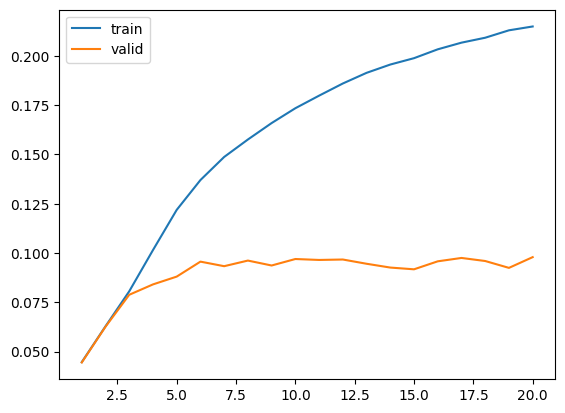

In [26]:

import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [27]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

In [28]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

<ipython-input-28-2a8fe09160a6>:24: UserWarning: `layout` parameter is deprecated, and it has no effect
  iface = gr.Interface(


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 28ms/step
Keyboard interruption in main thread... closing server.


In [29]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text
     

input_text='you have a'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 27ms/step


'you have a killing me'